## Wikipedia Page Views

In [1]:
import pandas as pd
import json
from ast import literal_eval
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import json
import base64
import requests
import bs4
from bs4 import BeautifulSoup
import re

from requests.structures import CaseInsensitiveDict
#from ratelimit import limits, RateLimitException, sleep_and_retry
# pip install ratelimit

In [6]:
# Read in speciesinfo CSV
species = pd.read_csv("csv/speciesinfo.csv", sep = ";")
species.drop_duplicates(inplace = True)
species = species.reset_index(drop = True)
len(species)

In [22]:
# pip3 install wikipedia-api
import wikipediaapi
# only english language pages
api = wikipediaapi.Wikipedia('en')

wikiurls = []
# loop through the unique species names
for name in species['scientific_name'].unique():
    # Spaces to be replaced with underscore for Wiki's API
    name = name.replace(" ", "_")
    # retrieve each species' page, will redirect when called with scientifc name
    p = api.page(name)
    try:
        # Fullurl will contain the title of the species' wiki article
        data = {'url': p.fullurl, 'scientific_name': name}
        wikiurls.append(data)
    # species did not return with a valid url, no page exists for the species
    except KeyError:
        pass
    
# investigate how many species left   
len(wikiurls)

Enhydra_lutris_nereis
Ovis_hodgsoni
Epioblasma_florentina
Sarracenia_rubra_jonesii
Pachycereus_militaris
Epioblasma_torulosa_gubernaculum
Fusconaia_edgariana
Pediocactus_paradinei
Echinocereus_schmollii
Toxolasma_cylindrella


In [31]:
def WikiPageView(title):
    """
    Function to call Wikipedia's Pageview API
    
    Parameters: string
    
    """
    
    # Calling monthly page views of each species from 2015-2020
    address = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/all-access/user/" + title + "/monthly/2015010100/2020123100"

    headers = CaseInsensitiveDict()
    headers["Accept"] = "application/json"
    # Personal username for identification for the Wikipedia API
    headers = {'User-Agent': 'reddalisa/3.10.6 (alisa.redding@helsinki.fi)'}
    
    resp = requests.get(address, headers=headers)
    details = resp.json()
    
    return details 
      
    
# Create an empty list to store the pageviews results into
newframe = []  

# loop over the urls to extract the titles of the wikipages
for n in range(len(wikiurls)):
    name = wikiurls[n]['url'].removeprefix("https://en.wikipedia.org/wiki/")
    # using the extracted name, run through the function
    result = WikiPageView(name)
    sci_name = wikiurls[n]['scientific_name']
    
    try:
        # loop over the json results to store the relevant information 
        for n in range(len(result['items'])):
            title = result['items'][n]['article']
            date = result['items'][n]['timestamp']
            # Remove 00 at end of date string that is marking the hour
            date = date[:-2]
            view = result['items'][n]['views']
            
            # create a dictionary object 
            data = {'title': title, 'date': date, 'views': view, 'scientific_name' : sci_name}
            newframe.append(data)
    # Some pages have not been incorporated into the PageViews API yet, they will be passed
    except KeyError:
        pass



In [37]:
# Create a dataframe from the list
#wikipage = pd.DataFrame(newframe)
#wikipage["datetime"] = wikipage["date"].apply(pd.to_datetime)
wikipage = wikipage.drop(columns = 'date')
wikipage['title'] = wikipage["title"].apply(lambda x: x.replace("_", " "))
wikipage['scientific_name'] = wikipage["scientific_name"].apply(lambda x: x.replace("_", " "))
#len(wikipage['name'].unique())

In [48]:
# view highest view count
wikipage.sort_values(by="views", ascending = False)

,title,views,scientific_name,datetime
2762,Tiger,694465,Panthera tigris,2020-03-01
9262,Red panda,652891,Ailurus fulgens,2017-05-01
614,Lion,574872,Panthera leo,2017-03-01
650,Lion,574083,Panthera leo,2020-03-01
2763,Tiger,540666,Panthera tigris,2020-04-01
...,...,...,...,...
34056,Milne-Edwards's sifaka,0,Propithecus edwardsi,2018-07-01
34057,Milne-Edwards's sifaka,0,Propithecus edwardsi,2018-08-01
34058,Milne-Edwards's sifaka,0,Propithecus edwardsi,2018-09-01
34059,Milne-Edwards's sifaka,0,Propithecus edwardsi,2018-10-01


In [46]:
speciesinfo = pd.merge(species, wikipage.groupby('scientific_name')['views'].sum().reset_index(), on='scientific_name', how = 'inner').drop_duplicates()

In [77]:
top20 = wikipage.groupby('name')['views'].sum().nlargest(20).reset_index()

In [47]:
speciesinfo.to_csv("csv/fullspeciesinfo.csv", sep = ";", index = False)

In [52]:
wikipage.to_csv("csv/wikipageviews.csv", sep = ";", index = False)

In [4]:
wiki["datetime"] = pd.to_datetime(wiki['datetime'])

In [39]:
temporal_wiki = wiki.groupby([(wiki.datetime.dt.year), (wiki.datetime.dt.month), (wiki.scientific_name)])['views'].sum()\
                .sort_values(ascending=False).rename_axis(["Year", "Month", "scientific_name"]).reset_index()

In [40]:
temporal_wiki

,Year,Month,scientific_name,views
0,2017,11,Canis lupus,20463
1,2018,6,Araucaria araucana,18266
2,2016,3,Araucaria araucana,17527
3,2020,8,Araucaria araucana,16448
4,2016,4,Araucaria araucana,15978
...,...,...,...,...
36108,2020,11,Bunopithecus hoolock,0
36109,2016,12,Villosa trabalis,0
36110,2020,8,Quadrula sparsa,0
36111,2019,2,Axis porcinus annamiticus,0


In [63]:
temporal_wiki.loc[temporal_wiki['Year'].isin([2020])].drop_duplicates("Month").sort_values("Month")

,Year,Month,scientific_name,views
35,2020,1,Araucaria araucana,13271
71,2020,2,Araucaria araucana,10920
63,2020,3,Araucaria araucana,11671
18,2020,4,Araucaria araucana,14283
6,2020,5,Araucaria araucana,15823
16,2020,6,Araucaria araucana,14484
8,2020,7,Araucaria araucana,15618
3,2020,8,Araucaria araucana,16448
22,2020,9,Araucaria araucana,14029
29,2020,10,Araucaria araucana,13771


In [47]:
top20wiki = wiki.groupby('scientific_name')['views'].sum().nlargest(20).reset_index()

In [78]:
# Read in the CITES data to join with the top 10 (or 20) most reported on species 
cites1 = pd.read_csv("csv/cites1.csv", delimiter = ';')

# Keep only most relevant columns
cites1 = cites1[['Kingdom', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Scientific Name', 'Listing', 'NativeDistributionFullNames', 'Extinct_Distribution']]

cites1 = cites1.rename(columns = {'Scientific Name' : 'scientific_name'})

In [79]:
top20

,name,views
0,Lion,13629976
1,Tiger,13092049
2,Giant panda,9965269
3,Blue whale,8733630
4,Jaguar,7867964
5,Cougar,7427753
6,Komodo dragon,7318871
7,Cheetah,7032511
8,Brown bear,6925285
9,Red panda,6605830


In [56]:
# Do the same for the entire dataframe
top20= top20.merge(cites1, on = 'scientific_name', how = 'left').drop_duplicates().reset_index(drop=True)

In [59]:
top20wiki

,scientific_name,views,Kingdom,Class,Order,Family,Genus,Species,Listing,NativeDistributionFullNames,Extinct_Distribution
0,Araucaria araucana,884780,Plantae,NaN,Pinales,Araucariaceae,Araucaria,araucana,I,"Argentina,Chile",NaN
1,Canis lupus,315399,Animalia,Mammalia,Carnivora,Canidae,Canis,lupus,I/II,"Afghanistan,Albania,Armenia,Azerbaijan,Belarus...","Austria,Bangladesh,Belgium,Denmark,Ireland,Jap..."
2,Saussurea costus,173419,Plantae,NaN,Asterales,Compositae,Saussurea,costus,I,"India,Pakistan",NaN
3,Ursus arctos,150634,Animalia,Mammalia,Carnivora,Ursidae,Ursus,arctos,I/II,"Afghanistan,Albania,Armenia,Austria,Azerbaijan...","Belgium,Denmark,Germany,Jordan,Liechtenstein,L..."
4,Dalbergia nigra,138788,Plantae,NaN,Fabales,Leguminosae,Dalbergia,nigra,I,Brazil,NaN
5,Encephalartos woodii,124417,Plantae,NaN,Cycadales,Zamiaceae,Encephalartos,woodii,I,NaN,South Africa
6,Peristeria elata,117725,Plantae,NaN,Orchidales,Orchidaceae,Peristeria,elata,I,"Colombia,Costa Rica,Ecuador,El Salvador,Panama...",NaN
7,Panthera leo,103654,Animalia,Mammalia,Carnivora,Felidae,Panthera,leo,I/II,"Angola,Benin,Botswana,Burkina Faso,Cameroon,Ce...","Afghanistan,Algeria,Burundi,Congo,Djibouti,Egy..."
8,Panthera onca,98270,Animalia,Mammalia,Carnivora,Felidae,Panthera,onca,I,"Argentina,Belize,Bolivia (Plurinational State ...","El Salvador,United States of America,Uruguay"
9,Aloe polyphylla,97816,Plantae,NaN,Liliales,Liliaceae,Aloe,polyphylla,I,Lesotho,South Africa


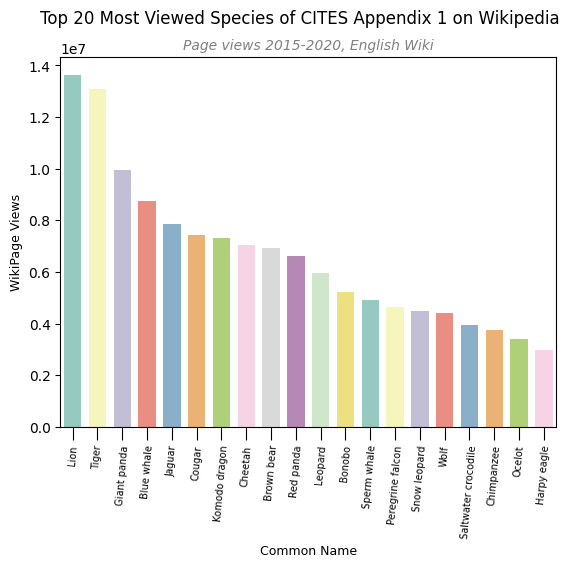

In [82]:
import seaborn as sns

ax = sns.barplot(
    x = 'name',
    y = 'views',
    #hue = 'Kingdom',
    data = top20, 
    width = 0.7, palette = 'Set3', dodge = False
)
ax.set_xlabel('Common Name', fontsize=9)
ax.set_ylabel('WikiPage Views', fontsize=9)


# Add suptitle above the title
plt.suptitle("Top 20 Most Viewed Species of CITES Appendix 1 on Wikipedia\n", fontsize=12)

# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
ax.set_title('Page views 2015-2020, English Wiki', fontsize = 10, color="grey", style='italic')


ax.tick_params(axis='x', rotation=85, length = 9, labelsize = 7, left = True)
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig('figures/top_20_commonnames_wiki.png', bbox_inches = 'tight')

In [65]:
google = pd.read_csv("csv/google_hits_species.csv", sep = ";")
google = google.drop_duplicates().reset_index(drop = True)

In [76]:
top20google = google.nlargest(columns = "gl_hits", n = 20)

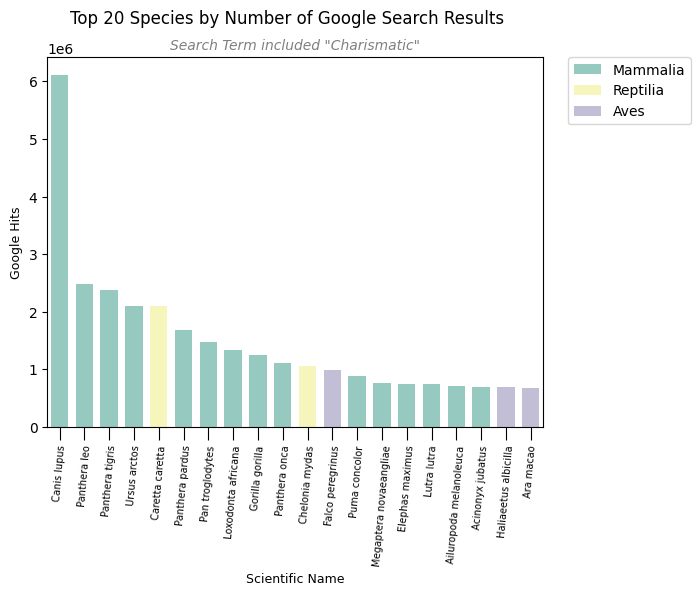

In [80]:
import seaborn as sns

ax = sns.barplot(
    x = 'scientific_name',
    y = 'gl_hits',
    hue = 'Class',
    data = top20google, 
    width = 0.7, palette = 'Set3', dodge = False
)
ax.set_xlabel('Scientific Name', fontsize=9)
ax.set_ylabel('Google Hits', fontsize=9)


# Add suptitle above the title
plt.suptitle("Top 20 Species by Number of Google Search Results\n", fontsize=12)

# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
ax.set_title('Search Term included "Charismatic"', fontsize = 10, color="grey", style='italic')


ax.tick_params(axis='x', rotation=85, length = 9, labelsize = 7, left = True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig('figures/top_20_species_google.png', bbox_inches = 'tight')